# **CLASSIFYING THE GEOLCATION OF TWEETS**

This report analyses different machine learning classification algorithms to output the geolocation of users according to their tweets. We use have three datasets in our disposition, namely the training dataset- to train the classifiers and tune parameters, the development dataset- to evaluate the performance of the classifiers trained on the training dataset, and the testing dataset- consisting of only features and no labels. The training dataset has 133796 instances, the development dataset has 11476 instances and the test dataset has 12019 instances. The classes are regions in the United States labelled as 'MIDWEST', 'NORTHEAST', 'SOUTH', 'WEST'.

In [1]:
import re
import ast
import csv
from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from matplotlib import pyplot

We load the `vocab.txt` file containing all the words mapped to their id and the `train_count.csv`, `dev_count.csv` and `test_count.csv` files in the notebook.

In [2]:
vocabulary = open('vocab.txt', 'r', encoding='utf8').readlines()
train_data_count = open('train_count.csv', 'r', encoding='utf8').readlines()[1:]
dev_data_count = open('dev_count.csv', 'r', encoding='utf8').readlines()[1:]
test_data_count = open('test_count.csv', 'r', encoding='utf8').readlines()[1:]

We convert `vocabulary` into a Python dictionary `word_dict` for ease of computation.

In [3]:
word_dict = dict()
for line in vocabulary:
    split_line = line.split('\t')
    word_dict[split_line[0]] = int(split_line[1])

A function `clean_count_and_labels` is defined to process raw count data and return a matrix of count values where each row represent an instance and each column represent a word in a dictionary, and a list of labels.

In [4]:
def clean_count_and_labels(raw_count_data, dictionary=word_dict):
    
    count = [[] for i in range(len(raw_count_data))]
    labels = []

    i = 0
    for line in raw_count_data:
        # add label to `labels`
        label = line.split(',')[0]
        labels.append(label)

        # add list of count values, as per index, to `count`
        count_list = ast.literal_eval(re.search('"(.*?)"', line).group(1))
        count_dict = {index: count for index, count in count_list}
        for j in dictionary.values():
            if j in count_dict:
                count[i].append(count_dict[j])
            else:
                count[i].append(0)
        i += 1
    
    return count, labels

Retrieve the full count values and labels for both the training and development datasets. The full count values matrices are converted to sparse matrices.

In [5]:
# TRAINING DATA
train_results = clean_count_and_labels(train_data_count)
full_train_count_values = csr_matrix(train_results[0])
train_labels = train_results[1]

In [6]:
# DEVELOPMENT DATA
dev_results = clean_count_and_labels(dev_data_count)
full_dev_count_values = csr_matrix(dev_results[0])
dev_labels = dev_results[1]

Using Chi-squared values, we get the 500 features (words) in the training dataset that have the highest dependence with the class labels.

In [7]:
K = 500

x2 = SelectKBest(chi2, k=K)
x2.fit(full_train_count_values, train_labels)

# reduce the count values to the selected features
train_count_values = x2.transform(full_train_count_values)
dev_count_values = x2.transform(full_dev_count_values)

We define a function that utilises Zero Rules to predict the majority class in the training dataset as labels and use it to get the `zero_r_predictions`.

In [8]:
def zero_r(train_labels, test_features):

    # get the frequency of each label
    label_counts = Counter()
    for label in train_labels:
        label_counts[label] += 1

    # retrieve the label with the highest frequency
    majority_class = label_counts.most_common()[0][0]

    predictions = [majority_class] * len(test_features.todense())
    
    return predictions

In [9]:
zero_r_predictions = zero_r(train_labels, dev_count_values)
print(f"Zero Rules predicted class distribution\t {Counter(zero_r_predictions)}")

Zero Rules predicted class distribution	 Counter({'NORTHEAST': 11475})


Now, we define and train the first classifier- the Multinomial Naive Bayes model on `train_count_values` and `train_labels` and use it to predict the labels from `dev_count_values`.

In [10]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(train_count_values, train_labels)

MultinomialNB()

In [11]:
mnb_predictions = list(mnb_classifier.predict(dev_count_values))
print(f'Multinomial Naive Bayes predicted class distribution\t {Counter(mnb_predictions)}')

Multinomial Naive Bayes predicted class distribution	 Counter({'SOUTH': 5838, 'NORTHEAST': 5236, 'WEST': 319, 'MIDWEST': 82})


The second model is the Logistic Regression model. Again, we train it on `train_count_values` and `train_labels` and predict the labels from `dev_count_values`.

In [12]:
MAX_ITER = 500

lr_classifier = LogisticRegression(max_iter=MAX_ITER)
lr_classifier.fit(train_count_values, train_labels)

LogisticRegression(max_iter=500)

In [13]:
lr_predictions = list(lr_classifier.predict(dev_count_values))
print(f'Logistic Regression predicted class distribution\t {Counter(lr_predictions)}')

Logistic Regression predicted class distribution	 Counter({'SOUTH': 5819, 'NORTHEAST': 5464, 'WEST': 167, 'MIDWEST': 25})


Similarly for a Multilayer Perceptron with one hidden layer containing 100 neurons and using as activation function, the sigmoid function.

In [14]:
ACTIVATION = 'logistic'
MAX_ITER = 2000

mlp_classifier = MLPClassifier(activation=ACTIVATION, max_iter=MAX_ITER)
mlp_classifier.fit(train_count_values, train_labels)

MLPClassifier(activation='logistic', max_iter=2000)

In [15]:
mlp_predictions = list(mlp_classifier.predict(dev_count_values))
print(f'Multilayer Perceptron predicted class distribution\t {Counter(mlp_predictions)}')

Multilayer Perceptron predicted class distribution	 Counter({'SOUTH': 5086, 'NORTHEAST': 5036, 'WEST': 702, 'MIDWEST': 651})


The last candidate classifier is the Decision Tree classifier- it uses information as splitting criteria and has a maximum depth of 50.

In [16]:
CRIT = 'entropy'
MAX_DEPTH = 50

dt_classifier = DecisionTreeClassifier(criterion=CRIT, max_depth=MAX_DEPTH)
dt_classifier.fit(train_count_values, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=50)

In [17]:
dt_predictions = list(dt_classifier.predict(dev_count_values))
print(f'Decision Tree predicted class distribution\t {Counter(dt_predictions)}')

Decision Tree predicted class distribution	 Counter({'SOUTH': 5579, 'NORTHEAST': 5392, 'WEST': 291, 'MIDWEST': 213})


We print out the empirical class distributions from the development dataset for reference.

In [18]:
print(f'Empirical Class distribution\t {Counter(dev_labels)}')

Empirical Class distribution	 Counter({'NORTHEAST': 4295, 'SOUTH': 4266, 'MIDWEST': 1484, 'WEST': 1430})


To evaluate the performances, the accuracy score and Macro F1 score is computed for each predictor.

In [19]:
# zero r
zero_r_acc = accuracy_score(dev_labels, zero_r_predictions)
zero_r_f1 = f1_score(dev_labels, zero_r_predictions, average='macro')

# mnb
mnb_acc = accuracy_score(dev_labels,mnb_predictions)
mnb_f1 = f1_score(dev_labels, mnb_predictions, average='macro')

# lr
lr_acc = accuracy_score(dev_labels, lr_predictions)
lr_f1 = f1_score(dev_labels, lr_predictions, average='macro')

# mlp
mlp_acc = accuracy_score(dev_labels, mlp_predictions)
mlp_f1 = f1_score(dev_labels, mlp_predictions, average='macro')

# dt
dt_acc = accuracy_score(dev_labels, dt_predictions)
dt_f1 = f1_score(dev_labels, dt_predictions, average='macro')

print(f'ZERO R\t\tAccuracy: {round(zero_r_acc, 2)}\tMacro F1: {round(zero_r_f1, 2)}')
print(f'MNB\t\tAccuracy: {round(mnb_acc, 2)}\tMacro F1: {round(mnb_f1, 2)}')
print(f'LR\t\tAccuracy: {round(lr_acc, 2)}\tMacro F1: {round(lr_f1, 2)}')
print(f'MLP\t\tAccuracy: {round(mlp_acc, 2)}\tMacro F1: {round(mlp_f1, 2)}')
print(f'DT\t\tAccuracy: {round(dt_acc, 2)}\tMacro F1: {round(dt_f1, 2)}')

ZERO R		Accuracy: 0.37	Macro F1: 0.14
MNB		Accuracy: 0.46	Macro F1: 0.29
LR		Accuracy: 0.46	Macro F1: 0.28
MLP		Accuracy: 0.41	Macro F1: 0.29
DT		Accuracy: 0.43	Macro F1: 0.28


We draw a bar chart of the evaluation metrics for visual illustration of the models' performances.

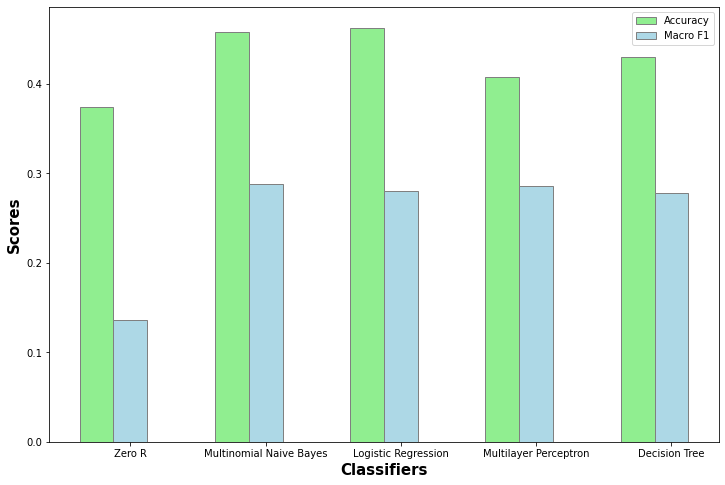

In [20]:
# set width of bars
BAR_WIDTH = 0.25
plot = pyplot.subplots(figsize=(12,8))

# set heights of bars
acc_list = [zero_r_acc, mnb_acc, lr_acc, mlp_acc, dt_acc]
f1_list = [zero_r_f1, mnb_f1, lr_f1, mlp_f1, dt_f1]

# set position of bar on x axis
br1 = [x for x in range(len(acc_list))]
br2 = [x + BAR_WIDTH for x in br1]

# make plot
pyplot.bar(br1, acc_list, color='lightgreen', width=BAR_WIDTH, edgecolor='grey', label='Accuracy')
pyplot.bar(br2, f1_list, color='lightblue', width=BAR_WIDTH, edgecolor='grey', label='Macro F1')

# adding labels and ticks
pyplot.xlabel('Classifiers', fontweight='bold', fontsize=15)
pyplot.ylabel('Scores', fontweight='bold', fontsize=15)
pyplot.xticks([x + BAR_WIDTH for x in br1], ['Zero R', 'Multinomial Naive Bayes', 'Logistic Regression', 'Multilayer Perceptron', 'Decision Tree'])
pyplot.legend()
pyplot.show()

We select the Logistic Regression classifier as our final model and use it to make predictions for the test dataset. `test_count_values` is computed in a similar fashion as for `train_count_values` and `dev_count_values` and `test_predictions` is computed using the pre-trained `lr_classifier`, but passing `test_count_values` for prediction.

In [21]:
test_results = clean_count_and_labels(test_data_count)
full_test_count_values = csr_matrix(test_results[0])

 # reduce `test_count_values` to the selected features
test_count_values = x2.transform(full_test_count_values)

In [22]:
test_predictions = list(lr_classifier.predict(test_count_values))
print(f'Logistic Regression predicted class distribution\t {Counter(test_predictions)}')

Logistic Regression predicted class distribution	 Counter({'SOUTH': 6179, 'NORTHEAST': 5666, 'WEST': 151, 'MIDWEST': 22})


Lastly, we write `test_predictions` on a csv file called `predictions.csv` for the Kaggle competition.

In [23]:
with open('predictions.csv', 'w', newline='') as file:
    
    writer = csv.writer(file)
    
    # write header row
    writer.writerow(["id", "region"])
    
    # write id and region in each row
    i = 1
    for prediction in test_predictions:
        writer.writerow([i, prediction])
        i += 1